In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import os

from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [2]:
image_path = os.path.join("../input/chest-xray-masks-and-labels/Lung Segmentation/CXR_png/")
mask_path = os.path.join("../input/chest-xray-masks-and-labels/data/Lung Segmentation/masks/")
images = os.listdir(image_path)
mask = os.listdir(mask_path)

mask = [fName.split(".png")[0] for fName in mask] 
image_file_name = [fName.split("_mask")[0] for fName in mask] 

In [3]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [4]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

In [5]:
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [6]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [7]:
dim = 256*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [01:10<00:00,  1.96it/s]


training set


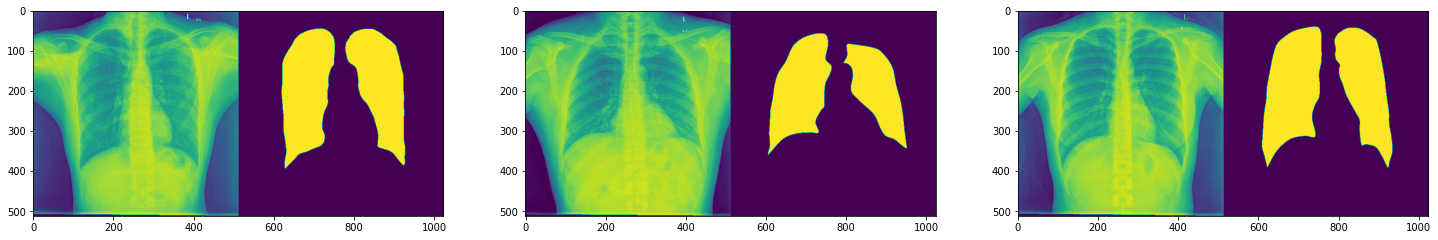

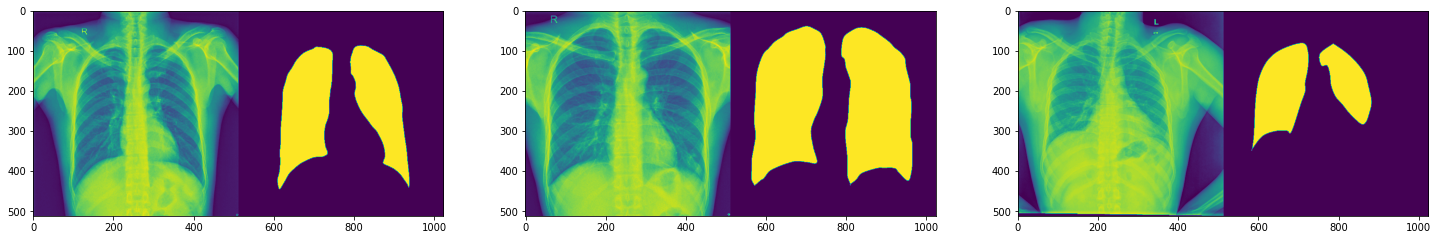

testing set


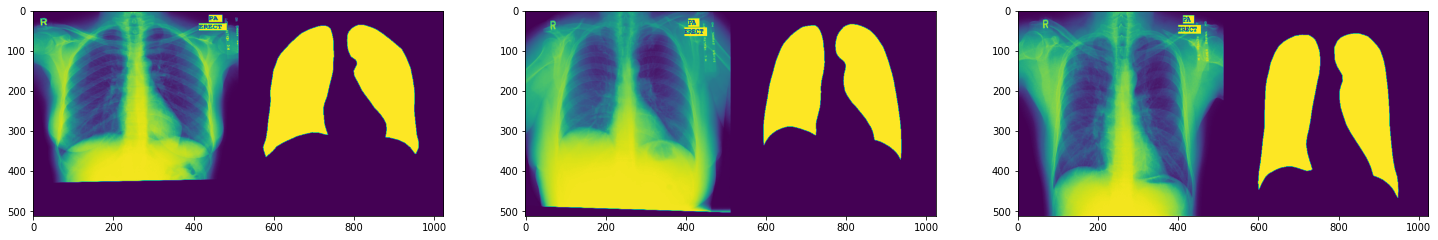

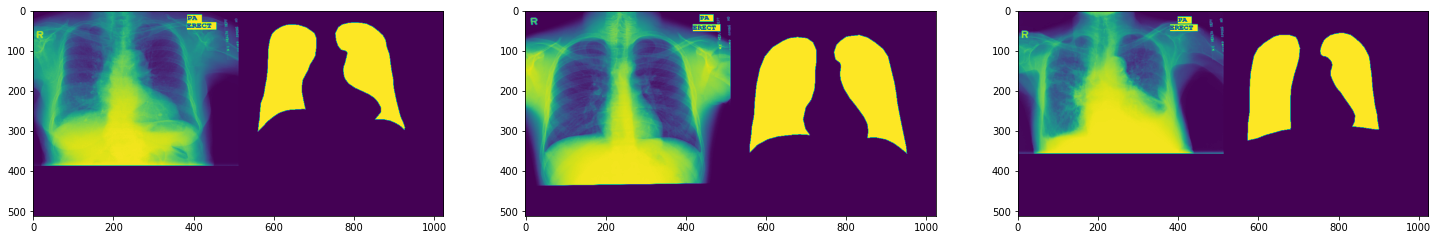

In [8]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [9]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [10]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

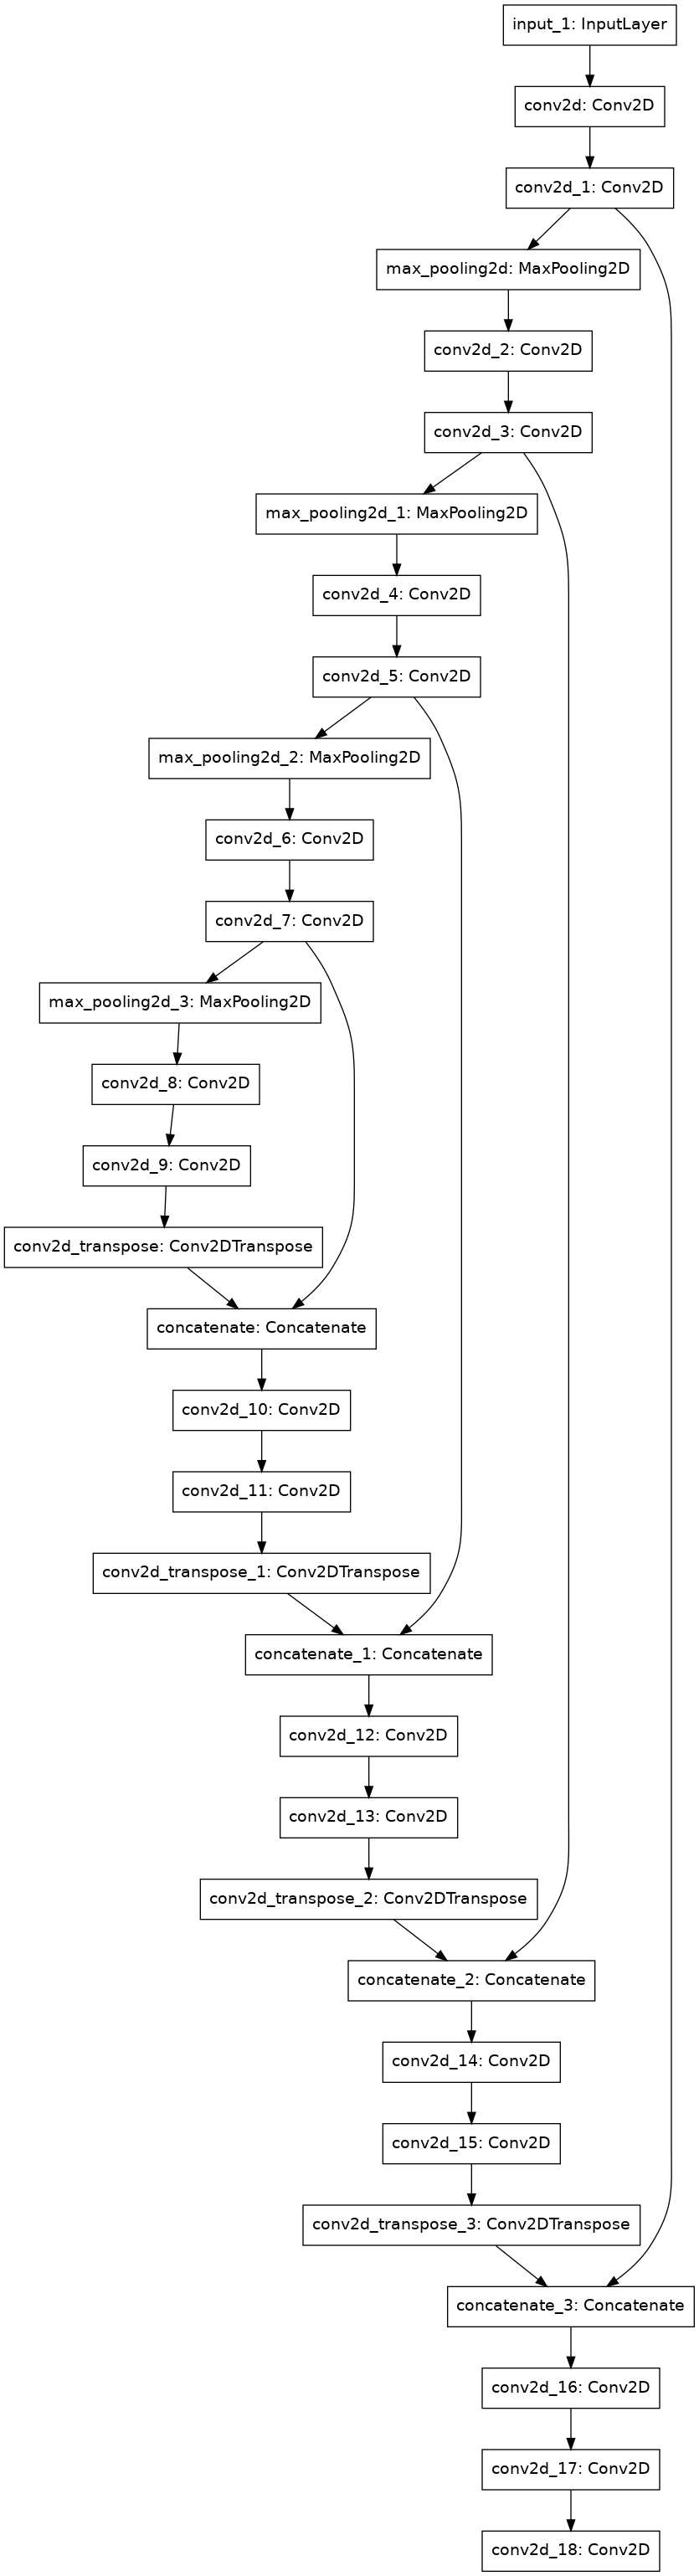

In [12]:
tf.keras.utils.plot_model(model, to_file='model.png')

In [13]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [14]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 42)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 42)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 30,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

model.save('my_model.h5') 

Epoch 1/30
36/36 [==============================] - 270s 7s/step - loss: -0.3453 - dice_coef: 0.3454 - binary_accuracy: 0.5299 - val_loss: -0.4934 - val_dice_coef: 0.4934 - val_binary_accuracy: 0.6431

Epoch 00001: val_loss improved from inf to -0.49337, saving model to cxr_reg_weights.best.hdf5
Epoch 2/30
36/36 [==============================] - 221s 6s/step - loss: -0.5422 - dice_coef: 0.5422 - binary_accuracy: 0.6524 - val_loss: -0.5467 - val_dice_coef: 0.5467 - val_binary_accuracy: 0.6242

Epoch 00002: val_loss improved from -0.49337 to -0.54671, saving model to cxr_reg_weights.best.hdf5
Epoch 3/30
36/36 [==============================] - 221s 6s/step - loss: -0.6043 - dice_coef: 0.6044 - binary_accuracy: 0.7335 - val_loss: -0.7912 - val_dice_coef: 0.7912 - val_binary_accuracy: 0.8951

Epoch 00003: val_loss improved from -0.54671 to -0.79117, saving model to cxr_reg_weights.best.hdf5
Epoch 4/30
36/36 [==============================] - 221s 6s/step - loss: -0.8137 - dice_coef: 0.813

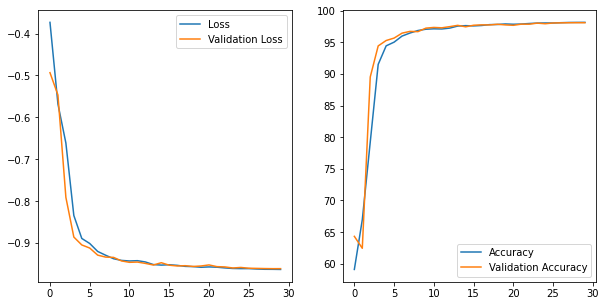

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [16]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 1.2 MB/s 


In [17]:

import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define model
model = sm.Unet(BACKBONE, classes=1,input_shape=(512,512,1),encoder_weights=None)

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 42)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 42)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 30,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

model.save('my_model.h5') 

Segmentation Models: using `tf.keras` framework.
Epoch 1/30
36/36 [==============================] - 23s 468ms/step - loss: -0.5319 - dice_coef: 0.5320 - binary_accuracy: 0.7372 - val_loss: -0.0227 - val_dice_coef: 0.0227 - val_binary_accuracy: 0.7476

Epoch 00001: val_loss did not improve from -0.96141
Epoch 2/30
36/36 [==============================] - 14s 386ms/step - loss: -0.7473 - dice_coef: 0.7473 - binary_accuracy: 0.9573 - val_loss: -0.4692 - val_dice_coef: 0.4692 - val_binary_accuracy: 0.8462

Epoch 00002: val_loss did not improve from -0.96141
Epoch 3/30
36/36 [==============================] - 14s 387ms/step - loss: -0.8095 - dice_coef: 0.8095 - binary_accuracy: 0.9707 - val_loss: -0.6090 - val_dice_coef: 0.6090 - val_binary_accuracy: 0.9080

Epoch 00003: val_loss did not improve from -0.96141
Epoch 4/30
36/36 [==============================] - 14s 388ms/step - loss: -0.8404 - dice_coef: 0.8404 - binary_accuracy: 0.9746 - val_loss: -0.6823 - val_dice_coef: 0.6823 - val_bina

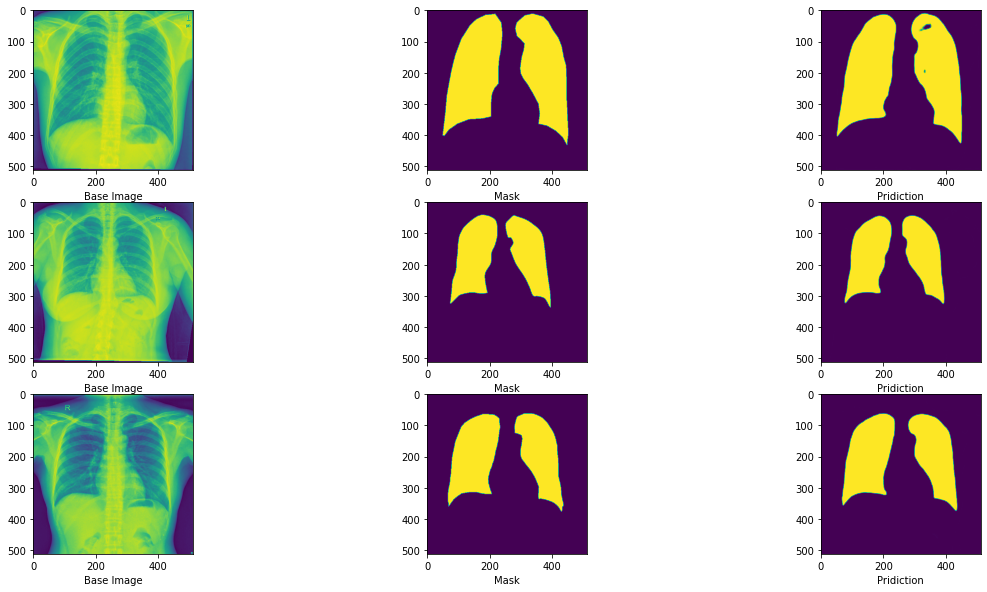

In [18]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")

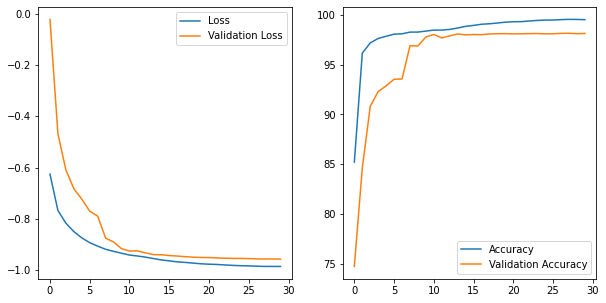

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [20]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define model
model = sm.Unet(BACKBONE, classes=1,input_shape=(512,512,1),encoder_weights=None)

model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 42)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 42)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 30,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

model.save('my_model.h5') 

Epoch 1/30
36/36 [==============================] - 24s 504ms/step - loss: -0.5044 - dice_coef: 0.5045 - binary_accuracy: 0.8625 - val_loss: -9.6903e-07 - val_dice_coef: 9.6903e-07 - val_binary_accuracy: 0.7458

Epoch 00001: val_loss did not improve from -0.96141
Epoch 2/30
36/36 [==============================] - 17s 470ms/step - loss: -0.7687 - dice_coef: 0.7687 - binary_accuracy: 0.9689 - val_loss: -0.0149 - val_dice_coef: 0.0149 - val_binary_accuracy: 0.7502

Epoch 00002: val_loss did not improve from -0.96141
Epoch 3/30
36/36 [==============================] - 17s 472ms/step - loss: -0.8443 - dice_coef: 0.8443 - binary_accuracy: 0.9731 - val_loss: -0.2394 - val_dice_coef: 0.2394 - val_binary_accuracy: 0.7619

Epoch 00003: val_loss did not improve from -0.96141
Epoch 4/30
36/36 [==============================] - 17s 470ms/step - loss: -0.8803 - dice_coef: 0.8803 - binary_accuracy: 0.9761 - val_loss: -0.5342 - val_dice_coef: 0.5342 - val_binary_accuracy: 0.8524

Epoch 00004: val_los

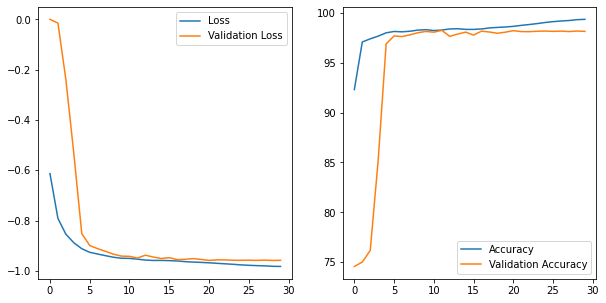

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

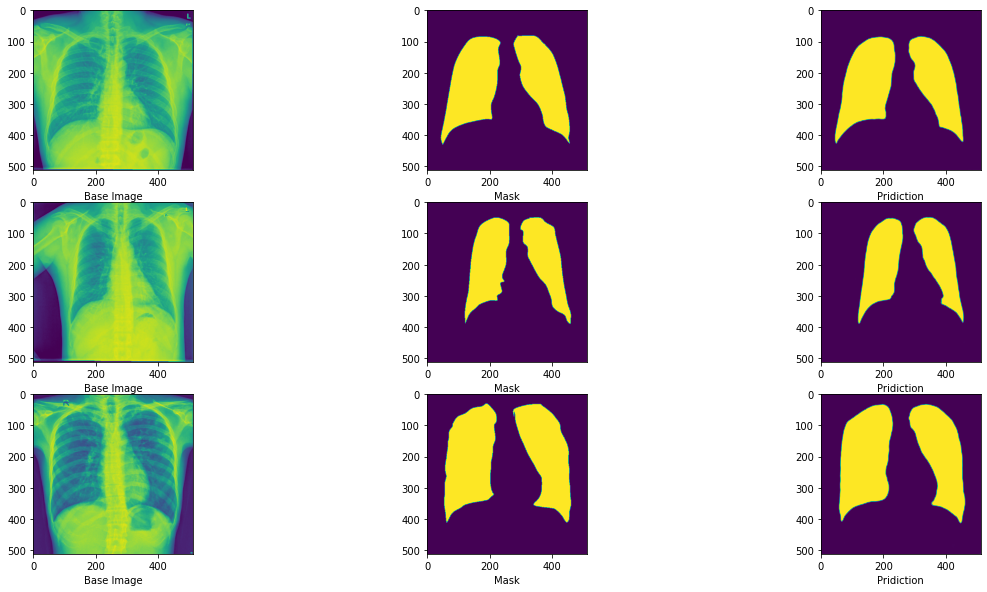

In [22]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")

Качество помог улучшить callback ReduceLROnPlateau  уменьшая скорость обучения. Полученные модели хорошо сегментируют обьект